In [6]:
import numpy as np
from matplotlib import pyplot as plt

import torch
import coremltools as ct
from tqdm import tqdm

from models import ResUNet, DDPM

In [7]:
device = torch.device("cpu")

In [8]:
ddpm = DDPM(
    model=ResUNet(
        in_channels=3, hidden_channels=64, use_norm_layer=True),
    device=device,
    timesteps=1000
)

In [9]:
checkpoint = torch.load("logs/exp_11_64px/checkpoint.pt", map_location=device)
ddpm.load_state_dict(checkpoint["net_state_dict"])
ddpm = ddpm.to(device)
ddpm.eval()
#ddpm = ddpm.to(torch.float16)
net = ddpm.model

In [10]:
example_input1 = (
    torch.randn(1, 3, 64, 64),
    torch.IntTensor([[1]]),
)

net_traced = torch.jit.trace(
    net,
    example_input1,
)

In [11]:
# check forward pass
net_traced(*example_input1).shape

torch.Size([1, 3, 64, 64])

In [12]:
example_input2 = (
    torch.randn(1, 3, 64, 64),
    torch.IntTensor([1]),
    torch.randn(1, 3, 64, 64),
)

ddpm_traced = torch.jit.trace(
    ddpm,
    example_inputs=example_input2,
)

In [13]:
# check forward pass
ddpm_traced(*example_input2).shape

torch.Size([1, 3, 64, 64])

In [14]:
model_name = "cifar64_net_coreml"

input_shape = ct.Shape(shape=(
    # ct.RangeDim(lower_bound=1, upper_bound=32, default=1),
    1, 3, 64, 64
))
timestep_shape = ct.Shape(shape=(
    # ct.RangeDim(lower_bound=1, upper_bound=32, default=1),
    1,
    1
))

coreml_inputs = [
    ct.TensorType(name="input", shape=input_shape, dtype=np.float32),
    ct.TensorType(name="timestep", shape=timestep_shape, dtype=np.int32)
]

coreml_program = ct.convert(
    net_traced,
    convert_to="mlprogram",
    inputs=coreml_inputs,
    outputs=[ct.TensorType(name="output")],
 )

# Save the converted model.
coreml_program.save(f"{model_name}.mlpackage")

# Using image_input in the inputs parameter:
# Convert to Core ML neural network using the Unified Conversion API.
coreml_model = ct.convert(
    net_traced,
    inputs=coreml_inputs,
    outputs=[ct.TensorType(name="output")],
)

# Save the converted model.
coreml_model.save(f"{model_name}.mlmodel")

Translating MIL ==> NeuralNetwork Ops:  26%|███▍         | 200/764 [00:00<00:00, 1989.40 ops/s]Const w.3 was already added.
Const w.5 was already added.
Translating MIL ==> NeuralNetwork Ops: 100%|██████████████| 764/764 [00:02<00:00, 305.31 ops/s]


In [15]:
# check inference of coreml models

input_tensor = np.random.randn(1, 3, 64, 64)

ret1 = coreml_program.predict({
    "input": input_tensor,
     "timestep": np.array([[100]]).astype(np.int32),
})["output"]

ret2 = coreml_model.predict({
    "input": input_tensor,
     "timestep": np.array([[100]]).astype(np.int32),
})["output"]

print(ret1.shape)
print(ret2.shape)

(1, 3, 64, 64)
(1, 3, 64, 64)


In [16]:
# uses ANE
for t in tqdm(range(1000)):
    ret1 = coreml_program.predict({
        "input": input_tensor,
         "timestep": np.array([[t]]).astype(np.int32),
    })["output"]

100%|█████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 114.41it/s]


In [17]:
model_name = "cifar64_ddpm_coreml"
batch_size = 4

input_shape = ct.Shape(shape=(batch_size, 3, 64, 64))
timestep_shape = ct.Shape(shape=(1,))
z_shape = ct.Shape(shape=(batch_size, 3, 64, 64))

coreml_inputs = [
    ct.TensorType(name="input", shape=input_shape, dtype=np.float32),
    ct.TensorType(name="timestep", shape=timestep_shape, dtype=np.int32),
    ct.TensorType(name="z", shape=input_shape, dtype=np.float32),
]

coreml_program_ddpm = ct.convert(
    ddpm_traced,
    convert_to="mlprogram",
    inputs=coreml_inputs,
    outputs=[ct.TensorType(name="output")],
    compute_units=ct.ComputeUnit.ALL,
    minimum_deployment_target=ct.target.macOS13,
 )

# Save the converted model.
coreml_program_ddpm.save(f"{model_name}.mlpackage")

Running MIL backend_mlprogram pipeline: 100%|████████████| 10/10 [00:00<00:00, 772.55 passes/s]


In [18]:
seed = 103
x_t = torch.randn(batch_size, 3, 64, 64)

for t in tqdm(range(0, 1000)[::-1]):
    z = torch.randn_like(x_t)
    x_t = coreml_program_ddpm.predict({
        "input": x_t,
        "timestep": np.array([t], dtype=np.int32),
        "z": z,
    })["output"]
    x_t = torch.from_numpy(x_t)

x_t = x_t.numpy()
x_t = (x_t + 1.0) / 2.0
x_t = x_t.clip(0, 1)
x_t = (x_t*255).astype(np.uint8)

100%|█████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.77it/s]


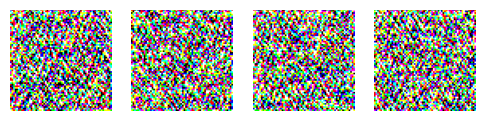

In [19]:
fig, ax = plt.subplots(1, x_t.shape[0], figsize=(6,4))
for i in range(x_t.shape[0]):
    ax[i].imshow(x_t[i].transpose(1, 2, 0))
    ax[i].set_axis_off()